### Open and View Datasets

In [35]:
path_complaints = "complaints.xlsx"

In [36]:
import pandas as pd

complaints_data = pd.read_excel(path_complaints)
complaints_data.columns = complaints_data.columns.str.lower().str.replace(' ', '_', regex=False)
complaints_data.rename(columns={'complaint': 'complaint_text'}, inplace=True)

### Text-Bracket Extraction (NLP)

In [37]:
from transformers import pipeline
from datasets import load_dataset
import torch
import numpy as np
import matplotlib.pyplot as plt

print("Hugging Face and essential packages are working!")

Hugging Face and essential packages are working!


In [38]:
import os
from huggingface_hub import login

token = os.getenv("HUGGINGFACE_TOKEN")

if token:
    login(token=token)
    print("Logged in successfully!")
else:
    print("Token not found. Make sure it's stored correctly.")

Logged in successfully!


In [39]:
import os
from huggingface_hub import login

token = os.getenv("HUGGINGFACE_TOKEN")

In [40]:
import pandas as pd
import re
import spacy
import time
from collections import Counter, defaultdict

# Load spaCy NLP model (optimized for efficiency)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

def replace_user_ids(text):
    """Replace 5-digit user IDs with [USER ID]"""
    return re.sub(r'\b\d{5}\b', '[USER ID]', text)

def split_into_brackets(text):
    """Split text into sub-phrases (Nebensätze) using common separators, including newlines and periods."""
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
    return [p.strip() for p in re.split(r'[.,:;\-\n]', text) if p.strip()]

def extract_phrases(merged_data):
    """
    Extract general_phrases and category_phrases based on frequency across categories.
    General phrases appear across multiple categories, while category phrases are unique to one category.
    """
    all_phrases = []
    phrase_category_map = defaultdict(set)
    
    for _, row in merged_data.iterrows():
        category = row['category']
        for phrase in row['bracket_phrases']:
            all_phrases.append(phrase)
            phrase_category_map[phrase].add(category)
    
    phrase_counts = Counter(all_phrases)
    total_complaints = len(merged_data)

    # General phrases appear across multiple categories & are moderately frequent (not too rare, not too common)
    general_phrases = {
        phrase for phrase, cats in phrase_category_map.items() 
        if len(cats) > 1 and 0.02 < phrase_counts[phrase] / total_complaints <= 0.9
    }

    # Category phrases are specific to a single category
    category_phrases = {phrase for phrase, cats in phrase_category_map.items() if len(cats) == 1}

    # Assign extracted phrases back to dataframe
    merged_data['general_phrases'] = merged_data['bracket_phrases'].apply(lambda phrases: [p for p in phrases if p in general_phrases])
    merged_data['category_phrases'] = merged_data['bracket_phrases'].apply(lambda phrases: [p for p in phrases if p in category_phrases])

    return merged_data

def process_complaints(merged_data):
    start_time = time.time()
    
    # Step 1: Replace user IDs
    merged_data['temp_complaint'] = merged_data['complaint_text'].apply(replace_user_ids)
    print(f"Step 1: Replaced user IDs - {time.time() - start_time:.2f}s")
    
    # Step 2: Extract phrases from brackets
    merged_data['bracket_phrases'] = merged_data['temp_complaint'].apply(split_into_brackets)
    print(f"Step 2: Split into brackets - {time.time() - start_time:.2f}s")
    
    # Step 3: Extract general and category phrases correctly
    merged_data = extract_phrases(merged_data)
    print(f"Step 4: Extracted general and category phrases - {time.time() - start_time:.2f}s")
    
    # Step 4: Drop unnecessary columns
    merged_data.drop(columns=['temp_complaint', 'bracket_phrases'], inplace=True)
    print(f"Step 5: Dropped intermediate columns - {time.time() - start_time:.2f}s")
    
    print(f"Total Processing Time: {time.time() - start_time:.2f}s")
    return merged_data

# Run the processing pipeline
complaint_analysis = process_complaints(complaints_data)
complaint_analysis

Step 1: Replaced user IDs - 0.11s
Step 2: Split into brackets - 0.34s
Step 4: Extracted general and category phrases - 2.02s
Step 5: Dropped intermediate columns - 2.02s
Total Processing Time: 2.02s


,customer_id,complaint_text,category,general_phrases,category_phrases
0,17256,Subject: Official Complaint.\n\n The unders...,Connection Problem,[This situation has greatly impacted my abilit...,"[My internet connection has been unreliable, f..."
1,18490,Subject: Official Complaint.\n\n The unders...,Service Disruption,[The lack of resolution is causing frustration...,[My internet service was down for an entire da...
2,14439,Subject: Official Complaint.\n\n The unders...,Billing Issue,[This ongoing problem has caused significant d...,[There are charges on my bill that I don’t rec...
3,18777,Subject: Official Complaint.\n\n The unders...,Service Disruption,[The lack of resolution is causing frustration...,[I’ve experienced several service interruption...
4,16143,Subject: Official Complaint.\n\n The unders...,Connection Problem,[This situation has greatly impacted my abilit...,"[Despite upgrading to a higher, speed plan, th..."
...,...,...,...,...,...
3495,19117,Subject: Official Complaint.\n\n The unders...,Unauthorized Charges,"[As a result of this issue, I have missed impo...",[The support team handled an unauthorized char...
3496,18994,Subject: Official Complaint.\n\n The unders...,Billing Issue,[This situation has greatly impacted my abilit...,"[A billing discrepancy was identified, but the..."
3497,13276,Subject: Official Complaint.\n\n The unders...,Unauthorized Charges,[This ongoing problem has caused significant d...,"[There was an unauthorized charge on my bill, ..."
3498,12400,Subject: Official Complaint.\n\n The unders...,Connection Problem,[The lack of resolution is causing frustration...,"[There was an issue with the internet speed, b..."


### Complaint Feature Creation (LLM)

In [ ]:
import time
import re
import spacy
import pickle
from transformers import pipeline

# ✅ Load Models
print("🔄 Loading models...")
llm_pipeline = pipeline("text2text-generation", model="google/flan-t5-base")
nlp = spacy.load("en_core_web_sm")

# 🎯 Define Features & Prompts
feature_prompts = {
    "issue_resolved": "Was the issue resolved?",
    "product_related": "Does the user have bad connection or interruptions?",
    "refund_or_correction_needed": "Is the customer charged or billed wrongly?"
}

# 📌 Function to detect issue persistence using SpaCy
def detect_past_tense(text):
    """Detects whether an issue is described in the past, assuming persistence otherwise."""
    doc = nlp(text)

    # Check for "has been" or "have been" (indicates ongoing issue)
    if re.search(r"has\s?.?been|have\s?.?been", text.lower()):
        return False  # Persistent issue

    # Count past tense verbs
    past_count = sum(1 for token in doc if token.tag_ in ["VBD", "VBN"])
    total_verbs = sum(1 for token in doc if token.pos_ == "VERB")

    # Classify based on verb tense ratio
    return past_count / total_verbs > 0.5 if total_verbs > 0 else False

# 📌 Function to extract features only for **unique phrases**
def extract_features(df):
    """Extracts features efficiently by processing unique phrases only."""
    start_time = time.time()
    
    # ✅ Get unique phrases
    unique_phrases = df["category_phrases"].dropna().unique()
    results = {}

    for text in unique_phrases:
        feature_values = {}

        # ✅ Extract LLM-based features
        for feature, prompt in feature_prompts.items():
            input_prompt = f"{prompt} Only answer 'Yes' or 'No'. Context: {text}"
            try:
                response = llm_pipeline(input_prompt, max_length=5, do_sample=False)[0]['generated_text'].strip().lower()
                feature_values[feature] = response in ["yes", "true"]  # Convert to boolean
            except Exception as e:
                feature_values[feature] = None  # Handle errors

        # ✅ Extract SpaCy-based feature
        feature_values["issue_not_persistent"] = detect_past_tense(text)

        # ✅ Store results for this phrase
        results[text] = feature_values

    print(f"\n✅ Feature extraction completed in {time.time() - start_time:.2f}s 🚀")
    
    # Convert to DataFrame
    features_df = pd.DataFrame.from_dict(results, orient="index").reset_index()
    features_df.rename(columns={"index": "category_phrases"}, inplace=True)
    
    return features_df

# 🔹 Load the trained model (processed unique phrases with features)
model_filename = "complaint_analysis_model.pkl"
with open(model_filename, "rb") as file:
    trained_features = pickle.load(file)

# ✅ Ensure `category_phrases` column exists
if "category_phrases" not in complaint_analysis.columns:
    raise ValueError("⚠️ The dataset must contain a 'category_phrases' column!")

# ✅ Standardize text for proper merging
def clean_text(text):
    """Ensures all category_phrases are consistently formatted."""
    if isinstance(text, list):
        return " ".join(map(str, text))
    return str(text).strip().lower()

# 🔹 Apply standardization
trained_features["category_phrases"] = trained_features["category_phrases"].apply(clean_text)
complaint_analysis["category_phrases"] = complaint_analysis["category_phrases"].apply(clean_text)

# ✅ Run feature extraction on all phrases
print("🔄 Running classification on all phrases...")
classified_features = extract_features(complaint_analysis[["category_phrases"]])

# ✅ Merge classified features with the dataset
complaint_analysis = complaint_analysis.merge(classified_features, on="category_phrases", how="left")

# 🔥 **Fix Duplicate Columns** (Remove `_x` and `_y`)
for col in classified_features.columns:
    if f"{col}_x" in complaint_analysis.columns and f"{col}_y" in complaint_analysis.columns:
        complaint_analysis[col] = complaint_analysis[f"{col}_x"].combine_first(complaint_analysis[f"{col}_y"])
        complaint_analysis.drop(columns=[f"{col}_x", f"{col}_y"], inplace=True)

print("✅ Model successfully applied. Predictions are now available in `complaint_analysis`.")

In [72]:
complaint_analysis

,customer_id,complaint_text,category,general_phrases,category_phrases,issue_resolved,product_related,refund_or_correction_needed,issue_not_persistent
0,17256,Subject: Official Complaint.\n\n The unders...,Connection Problem,[This situation has greatly impacted my abilit...,my internet connection has been unreliable fre...,False,True,False,False
1,18490,Subject: Official Complaint.\n\n The unders...,Service Disruption,[The lack of resolution is causing frustration...,my internet service was down for an entire day...,False,True,False,True
2,14439,Subject: Official Complaint.\n\n The unders...,Billing Issue,[This ongoing problem has caused significant d...,there are charges on my bill that i don’t reco...,False,False,True,False
3,18777,Subject: Official Complaint.\n\n The unders...,Service Disruption,[The lack of resolution is causing frustration...,i’ve experienced several service interruptions...,False,True,False,False
4,16143,Subject: Official Complaint.\n\n The unders...,Connection Problem,[This situation has greatly impacted my abilit...,despite upgrading to a higher speed plan the c...,False,True,False,False
...,...,...,...,...,...,...,...,...,...
3495,19117,Subject: Official Complaint.\n\n The unders...,Unauthorized Charges,"[As a result of this issue, I have missed impo...",the support team handled an unauthorized charg...,True,False,True,True
3496,18994,Subject: Official Complaint.\n\n The unders...,Billing Issue,[This situation has greatly impacted my abilit...,a billing discrepancy was identified but the s...,True,False,True,True
3497,13276,Subject: Official Complaint.\n\n The unders...,Unauthorized Charges,[This ongoing problem has caused significant d...,there was an unauthorized charge on my bill bu...,True,False,True,True
3498,12400,Subject: Official Complaint.\n\n The unders...,Connection Problem,[The lack of resolution is causing frustration...,there was an issue with the internet speed but...,True,True,False,True


Here we aggregate the values to merged_data (just use the merged_data already loaded)

In [70]:
#
merged_data = pd.read_csv('merged_data.csv')

In [76]:
import pandas as pd

# Create 'no_unresolved_issues' and 'no_resolved_issues' by counting occurrences
merged_data['no_unresolved_issues'] = merged_data['customer_id'].map(
    complaint_analysis[complaint_analysis['issue_resolved'] == False]['customer_id'].value_counts()
).fillna(0).astype(int)

merged_data['no_resolved_issues'] = merged_data['customer_id'].map(
    complaint_analysis[complaint_analysis['issue_resolved'] == True]['customer_id'].value_counts()
).fillna(0).astype(int)

# Extract counts for specific issue types where issue_resolved == False
unresolved_issues = complaint_analysis[complaint_analysis['issue_resolved'] == False]

for feature in ['product_related', 'refund_or_correction_needed', 'issue_not_persistent']:
    merged_data[f'count_{feature}'] = merged_data['customer_id'].map(
        unresolved_issues.groupby('customer_id')[feature].sum()
    ).fillna(0).astype(int)

# Concatenate all 'category_phrases' for unresolved issues per customer
merged_data['issue_summary'] = merged_data['customer_id'].map(
    unresolved_issues.groupby('customer_id')['category_phrases'].apply(lambda x: ' | '.join(x))
).fillna('')

# Concatenate all 'general_phrase' for unresolved issues per customer as sentiment summary
merged_data['sentiment_summary'] = merged_data['customer_id'].map(
    unresolved_issues.groupby('customer_id')['general_phrases']
    .apply(lambda x: ' | '.join(sum(x, []) if isinstance(x.iloc[0], list) else x))
).fillna('')

# Display final DataFrame
print(merged_data.head())

   Unnamed: 0  customer_id  birth_date   join_date  churn_in_3mos  \
0           0        10000  1994-08-13  2015-11-22              0   
1           1        10001  1994-06-25  2015-01-12              1   
2           2        10002  2008-06-10  2020-05-22              0   
3           3        10003  1970-09-04  2017-11-10              0   
4           4        10004  1969-11-06  2019-05-19              0   

   plan_pay-as-you-go  plan_postpaid  plan_prepaid  age_at_joining  \
0               False           True         False              21   
1                True          False         False              20   
2               False          False          True              11   
3               False          False          True              47   
4               False          False          True              49   

   years_on_plan  ...            category  \
0       6.115068  ...                 NaN   
1       6.975342  ...  Service Disruption   
2       1.613699  ...        

In [77]:
merged_data

,Unnamed: 0,customer_id,birth_date,join_date,churn_in_3mos,plan_pay-as-you-go,plan_postpaid,plan_prepaid,age_at_joining,years_on_plan,...,category,issue,consequence,no_unresolved_issues,no_resolved_issues,count_product_related,count_refund_or_correction_needed,count_issue_not_persistent,issue_summary,sentiment_summary
0,0,10000,1994-08-13,2015-11-22,0,False,True,False,21,6.115068,...,NaN,No issue,No action required,0,0,0,0,0,,
1,1,10001,1994-06-25,2015-01-12,1,True,False,False,20,6.975342,...,Service Disruption,There have been frequent interruptions to my s...,This situation has greatly impacted my ability...,1,0,1,0,0,there have been frequent interruptions to my s...,This situation has greatly impacted my ability...
2,2,10002,2008-06-10,2020-05-22,0,False,False,True,11,1.613699,...,NaN,No issue,No action required,0,0,0,0,0,,
3,3,10003,1970-09-04,2017-11-10,0,False,False,True,47,4.145205,...,NaN,No issue,No action required,0,0,0,0,0,,
4,4,10004,1969-11-06,2019-05-19,0,False,False,True,49,2.624658,...,Connection Problem,"My internet connection was unstable last week,...",The lack of resolution is causing frustration ...,0,1,0,0,0,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,19995,2007-07-30,2015-11-23,1,False,False,True,8,6.112329,...,Promotional Issue,"Despite contacting support, the promotional of...",This ongoing problem has caused significant di...,1,0,0,0,1,despite contacting support the promotional off...,This ongoing problem has caused significant di...
9996,9996,19996,1981-10-26,2018-03-18,0,False,False,True,36,3.794521,...,NaN,No issue,No action required,0,0,0,0,0,,
9997,9997,19997,1999-01-10,2012-12-02,0,False,True,False,13,9.087671,...,NaN,No issue,No action required,0,0,0,0,0,,
9998,9998,19998,1993-09-10,2015-09-09,0,False,True,False,22,6.317808,...,NaN,No issue,No action required,0,0,0,0,0,,


## Recommender System

In [78]:
import pandas as pd

# Assuming you already have the 'merged_data' dataframe
# If not, load it with your actual data source

# Create 'churn_proba' column based on 'churn_in_3mos'
merged_data["churn_proba"] = merged_data["churn_in_3mos"].apply(lambda x: 0.8 if x else 0.0)

# Define probability threshold
proba_threshold = 0.75

# Display the first few rows to verify
print(merged_data.head())

   Unnamed: 0  customer_id  birth_date   join_date  churn_in_3mos  \
0           0        10000  1994-08-13  2015-11-22              0   
1           1        10001  1994-06-25  2015-01-12              1   
2           2        10002  2008-06-10  2020-05-22              0   
3           3        10003  1970-09-04  2017-11-10              0   
4           4        10004  1969-11-06  2019-05-19              0   

   plan_pay-as-you-go  plan_postpaid  plan_prepaid  age_at_joining  \
0               False           True         False              21   
1                True          False         False              20   
2               False          False          True              11   
3               False          False          True              47   
4               False          False          True              49   

   years_on_plan  ...                                              issue  \
0       6.115068  ...                                           No issue   
1       6.97

### Create Segmentation Features

In [80]:
merged_data.head()

,Unnamed: 0,customer_id,birth_date,join_date,churn_in_3mos,plan_pay-as-you-go,plan_postpaid,plan_prepaid,age_at_joining,years_on_plan,...,issue,consequence,no_unresolved_issues,no_resolved_issues,count_product_related,count_refund_or_correction_needed,count_issue_not_persistent,issue_summary,sentiment_summary,churn_proba
0,0,10000,1994-08-13,2015-11-22,0,False,True,False,21,6.115068,...,No issue,No action required,0,0,0,0,0,,,0.0
1,1,10001,1994-06-25,2015-01-12,1,True,False,False,20,6.975342,...,There have been frequent interruptions to my s...,This situation has greatly impacted my ability...,1,0,1,0,0,there have been frequent interruptions to my s...,This situation has greatly impacted my ability...,0.8
2,2,10002,2008-06-10,2020-05-22,0,False,False,True,11,1.613699,...,No issue,No action required,0,0,0,0,0,,,0.0
3,3,10003,1970-09-04,2017-11-10,0,False,False,True,47,4.145205,...,No issue,No action required,0,0,0,0,0,,,0.0
4,4,10004,1969-11-06,2019-05-19,0,False,False,True,49,2.624658,...,"My internet connection was unstable last week,...",The lack of resolution is causing frustration ...,0,1,0,0,0,,,0.0


In [83]:
import re

columns = merged_data.columns
# Initialize lists
data_usage_cols = []
phone_usage_cols = []
use_app_cols = []

# Regex patterns for each type of usage
patterns = {
    'data_usage': r'^data_usage_',
    'phone_usage': r'^phone_usage_',
    'use_app': r'^use_app_'
}

# Loop through the column names and append to the respective list
for col in columns:
    if re.search(patterns['data_usage'], col):
        data_usage_cols.append(col)
    elif re.search(patterns['phone_usage'], col):
        phone_usage_cols.append(col)
    elif re.search(patterns['use_app'], col):
        use_app_cols.append(col)

# Print the lists to verify
print("Data Usage Columns:", data_usage_cols)
print("Phone Usage Columns:", phone_usage_cols)
print("App Usage Columns:", use_app_cols)

merged_data['monthly_avg_data'] = merged_data[data_usage_cols].mean(axis=1)

Data Usage Columns: ['data_usage_2021-01-01 00:00:00', 'data_usage_2021-02-01 00:00:00', 'data_usage_2021-03-01 00:00:00', 'data_usage_2021-04-01 00:00:00', 'data_usage_2021-05-01 00:00:00', 'data_usage_2021-06-01 00:00:00', 'data_usage_2021-07-01 00:00:00', 'data_usage_2021-08-01 00:00:00', 'data_usage_2021-09-01 00:00:00', 'data_usage_2021-10-01 00:00:00', 'data_usage_2021-11-01 00:00:00', 'data_usage_2021-12-01 00:00:00']
Phone Usage Columns: ['phone_usage_2021-01-01 00:00:00', 'phone_usage_2021-02-01 00:00:00', 'phone_usage_2021-03-01 00:00:00', 'phone_usage_2021-04-01 00:00:00', 'phone_usage_2021-05-01 00:00:00', 'phone_usage_2021-06-01 00:00:00', 'phone_usage_2021-07-01 00:00:00', 'phone_usage_2021-08-01 00:00:00', 'phone_usage_2021-09-01 00:00:00', 'phone_usage_2021-10-01 00:00:00', 'phone_usage_2021-11-01 00:00:00', 'phone_usage_2021-12-01 00:00:00']
App Usage Columns: ['use_app_2021-01-01 00:00:00', 'use_app_2021-02-01 00:00:00', 'use_app_2021-03-01 00:00:00', 'use_app_2021-04

In [86]:
# Select all columns that start with "plan_"
plan_columns = [col for col in merged_data.columns if col.startswith("plan_")]

# Extract plan names (removing "plan_" prefix)
plan_names = [col.replace("plan_", "") for col in plan_columns]

# Assign plan_type dynamically
merged_data["plan_type"] = np.select(
    [merged_data[col] == True for col in plan_columns],  # Conditions
    plan_names,  # Choices
    default="unknown"  # Default if no plan is True
)
# Display output
print(merged_data["plan_type"].head())

0         postpaid
1    pay-as-you-go
2          prepaid
3          prepaid
4          prepaid
Name: plan_type, dtype: object


In [89]:
import pandas as pd

# Assuming merged_data has 'plan_type' and 'monthly_avg_data' columns

# Compute plan-level average & rank in one step
merged_data["plan_rank"] = (
    merged_data.groupby("plan_type")["monthly_avg_data"]
    .transform("mean")  # Compute the average monthly data usage per plan
    .rank(method="dense", ascending=False)  # Rank based on the computed averages
)

# Display result
print(merged_data[["plan_type", "monthly_avg_data", "plan_rank"]].head())

       plan_type  monthly_avg_data  plan_rank
0       postpaid         76.915833        1.0
1  pay-as-you-go         12.286667        3.0
2        prepaid         36.716667        2.0
3        prepaid         31.731667        2.0
4        prepaid         36.001667        2.0


In [90]:
import pandas as pd

# Create equal-sized bins (terciles) based on `monthly_avg_data`
merged_data["data_bin_3"] = pd.qcut(
    merged_data["monthly_avg_data"], 
    q=3,  # Divides into 3 quantiles (terciles)
    labels=[1, 2, 3]  # Assigns 1 = lowest, 2 = middle, 3 = highest
)

# Convert to integer for readability
merged_data["data_bin_3"] = merged_data["data_bin_3"].astype(int)

# Display result
print(merged_data[["monthly_avg_data", "data_bin_3"]].head())

   monthly_avg_data  data_bin_3
0         76.915833           3
1         12.286667           1
2         36.716667           3
3         31.731667           2
4         36.001667           3


In [91]:
# Apply qcut within each plan_type
merged_data["data_bin_3"] = (
    merged_data.groupby("plan_type")["monthly_avg_data"]
    .transform(lambda x: pd.qcut(x, q=3, labels=[1, 2, 3], duplicates="drop"))  # Handle edge cases
)

# Convert to integer for readability
merged_data["data_bin_3"] = merged_data["data_bin_3"].astype(float).fillna(2).astype(int)  # Default to middle bin if NaN

# Display result
print(merged_data[["plan_type", "monthly_avg_data", "data_bin_3"]].head())

       plan_type  monthly_avg_data  data_bin_3
0       postpaid         76.915833           3
1  pay-as-you-go         12.286667           1
2        prepaid         36.716667           3
3        prepaid         31.731667           2
4        prepaid         36.001667           3


In [93]:
# Identify the last 4 months dynamically
last_4_months = sorted(use_app_cols, key=lambda x: x[-10:])[-4:]

# Count how many of the last 4 months each user was active
merged_data["active_last_4mos"] = merged_data[last_4_months].sum(axis=1)

# Define active users as those with more than 2 months of usage in the last 4 months
merged_data["recent_active_status"] = (merged_data["active_last_4mos"] > 2).astype(int)

In [96]:
merged_data['current_age'] = merged_data['age_at_joining'] + merged_data['years_on_plan']

In [97]:
# Bin `years_on_plan` into thirds (tenure_bin)
merged_data["tenure_bin"] = pd.qcut(
    merged_data["years_on_plan"], 
    q=3, 
    labels=[1, 2, 3],  # 1 = lowest, 3 = highest tenure
    duplicates="drop"
).astype(int)

# Bin `current_age` into thirds (age_group)
merged_data["age_group"] = pd.qcut(
    merged_data["current_age"], 
    q=3, 
    labels=[1, 2, 3],  # 1 = youngest, 3 = oldest
    duplicates="drop"
).astype(int)

# Display result
print(merged_data[["years_on_plan", "tenure_bin", "current_age", "age_group"]].head())

   years_on_plan  tenure_bin  current_age  age_group
0       6.115068           2    27.115068          1
1       6.975342           2    26.975342          1
2       1.613699           1    12.613699          1
3       4.145205           1    51.145205          3
4       2.624658           1    51.624658          3


In [98]:
merged_data.head()

,Unnamed: 0,customer_id,birth_date,join_date,churn_in_3mos,plan_pay-as-you-go,plan_postpaid,plan_prepaid,age_at_joining,years_on_plan,...,plan_type,plan_rank_x,plan_rank_y,plan_rank,data_bin_3,active_last_4mos,recent_active_status,current_age,tenure_bin,age_group
0,0,10000,1994-08-13,2015-11-22,0,False,True,False,21,6.115068,...,postpaid,139.0,1.0,1.0,3,3,1,27.115068,2,1
1,1,10001,1994-06-25,2015-01-12,1,True,False,False,20,6.975342,...,pay-as-you-go,889.0,3.0,3.0,1,4,1,26.975342,2,1
2,2,10002,2008-06-10,2020-05-22,0,False,False,True,11,1.613699,...,prepaid,896.0,2.0,2.0,3,4,1,12.613699,1,1
3,3,10003,1970-09-04,2017-11-10,0,False,False,True,47,4.145205,...,prepaid,2974.0,2.0,2.0,2,4,1,51.145205,1,3
4,4,10004,1969-11-06,2019-05-19,0,False,False,True,49,2.624658,...,prepaid,1088.0,2.0,2.0,3,2,0,51.624658,1,3


### Measuring Quantity / Intensity

In [127]:
# Function to filter issue_summary while ensuring "a / an" only appears after "for"
def filter_time_words(text):
    if pd.isna(text) or not isinstance(text, str):
        return None  # Skip non-string values

    doc = nlp(text.lower())  # Process text
    filtered_words = []
    
    # Define key patterns related to frequency, duration, and quantity
    time_units = {"day", "days", "week", "weeks", "month", "months", "year", "years", 
                  "time", "times", "hour", "hours", "minute", "minutes", "second", "seconds"}
    frequency_words = {"few", "several", "many", "frequent", "often", "repeatedly", 
                       "constantly", "always", "multiple", "entire", "whole", "all", "almost", "brief", "short"}
    number_words = {"one", "two", "three", "four", "five", "six", "seven", "eight", "nine", 
                    "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", 
                    "seventeen", "eighteen", "nineteen", "twenty", "thirty", "forty", "fifty", 
                    "sixty", "seventy", "eighty", "ninety", "hundred", "thousand"}
    indefinite_articles = {"a", "an"}

    previous_word = None  # Track the previous word for context

    # Iterate through the words in the sentence and keep only the relevant ones
    for token in doc:
        word = token.text

        # Allow only words that are in the predefined sets or are numeric
        if word in time_units or word in frequency_words or word in number_words or token.like_num:
            filtered_words.append(word)
            previous_word = word  # Update previous word

        # Ensure "a" or "an" only appears if preceded by "for"
        elif word in indefinite_articles and previous_word == "for":
            filtered_words.append(word)
            previous_word = word  # Update previous word

    # Reconstruct the sentence with only the relevant words in the original order
    return " ".join(filtered_words) if filtered_words else None

# Create the new feature directly in merged_data
merged_data["extracted_time_info"] = merged_data.apply(
    lambda row: filter_time_words(row["issue_summary"]) if (
        row["category"] in ["Service Disruption", "Connection Issue"] and row["no_unresolved_issues"] > 0
    ) else None, axis=1
)

In [130]:
# Function to compute intensity score based on extracted time info with refined weighting
def compute_intensity_score(text):
    if pd.isna(text) or not isinstance(text, str):
        return 0  # Default to 0 intensity if no valid text
    
    doc = nlp(text.lower())
    score = 0

    # Define scoring categories
    frequency_words = {"frequent", "often", "repeatedly", "constantly"}  # +3
    severity_words = {"entire", "whole", "all"}  # +3

    # Adjusted weight for different quantity expressions
    low_intensity_words = {"few", "brief", "short"}  # +1
    medium_intensity_words = {"several", "many", "multiple"}  # +2

    # Adjusted weight for duration-based severity
    duration_units = {
        "hour": 1, "hours": 2,
        "day": 3, "days": 4,
        "week": 5, "weeks": 6,
        "month": 7, "months": 8,
        "year": 9, "years": 10
    }

    for token in doc:
        if token.text in frequency_words:
            score += 3
        elif token.text in severity_words:
            score += 3
        elif token.text in low_intensity_words:
            score += 1
        elif token.text in medium_intensity_words:
            score += 2
        elif token.text in duration_units:
            score += duration_units[token.text]  # Assign weighted score for duration
        elif token.like_num:  # If token is a number, add 1 per occurrence
            score += 1

    return score

# Apply the function to create the 'issue_intensity_score' column directly in merged_data
merged_data["time_intensity_score"] = merged_data["extracted_time_info"].apply(compute_intensity_score)

In [131]:
merged_data.head()

,Unnamed: 0,customer_id,birth_date,join_date,churn_in_3mos,plan_pay-as-you-go,plan_postpaid,plan_prepaid,age_at_joining,years_on_plan,...,plan_rank,data_bin_3,active_last_4mos,recent_active_status,current_age,tenure_bin,age_group,extracted_time_info,issue_intensity_score,time_intensity_score
0,0,10000,1994-08-13,2015-11-22,0,False,True,False,21,6.115068,...,1.0,3,3,1,27.115068,2,1,None,0,0
1,1,10001,1994-06-25,2015-01-12,1,True,False,False,20,6.975342,...,3.0,1,4,1,26.975342,2,1,frequent,3,3
2,2,10002,2008-06-10,2020-05-22,0,False,False,True,11,1.613699,...,2.0,3,4,1,12.613699,1,1,None,0,0
3,3,10003,1970-09-04,2017-11-10,0,False,False,True,47,4.145205,...,2.0,2,4,1,51.145205,1,3,None,0,0
4,4,10004,1969-11-06,2019-05-19,0,False,False,True,49,2.624658,...,2.0,3,2,0,51.624658,1,3,None,0,0


### Decision Scores per Segment

In [152]:
# Define the updated scoring rules with estimated business value
updated_scoring_rules = {
    "data_bin_3": {
        "3": {"retention": 1, "xsell": 1, "upsell": 4},
        "2": {"retention": 3, "xsell": 3, "upsell": 2},
        "1": {"retention": 5, "xsell": 3, "upsell": 0}
    },
    "no_unresolved_issues": {
        ">2": {"retention": 5, "xsell": 4, "upsell": 4, "estimated_business_value": 3},
        "1": {"retention": 3, "xsell": 2, "upsell": 2, "estimated_business_value": 2},
        "0": {"retention": 2, "xsell": 1, "upsell": 1, "estimated_business_value": 1}
    },
    "plan_rank": {
        "3": {"retention": 4, "xsell": 5, "upsell": 0, "estimated_business_value": 3},
        "2": {"retention": 3, "xsell": 3, "upsell": 4, "estimated_business_value": 2},
        "1": {"retention": 2, "xsell": 1, "upsell": 4, "estimated_business_value": 1}
    },
    "tenure_bin": {
        "3": {"retention": 3, "xsell": 4, "upsell": 2, "estimated_business_value": 3},
        "2": {"retention": 3, "xsell": 3, "upsell": 4, "estimated_business_value": 2},
        "1": {"retention": 4, "xsell": 2, "upsell": 3, "estimated_business_value": 3}
    },
    "issue_category": {
        "support_issue": {
            "issue_intensity_score": {
                "high": {">4": {"retention": 3, "xsell": 1, "upsell": 1, "estimated_business_value": 3}},
                "medium": {">2, <=4": {"retention": 2, "xsell": 2, "upsell": 2, "estimated_business_value": 2}},
                "low": {">=2": {"retention": 1, "xsell": 1, "upsell": 3, "estimated_business_value": 1}}
            }
        },
        "refund_issue": {
            "Billing Issue": {"retention": 2, "xsell": 3, "upsell": 3, "estimated_business_value": 2},
            "Unauthorized Charges": {"retention": 2, "xsell": 3, "upsell": 3, "estimated_business_value": 2}
        },
        "promotional_issue": {
            "Promotional issue": {"retention": 3, "xsell": 2, "upsell": 2, "estimated_business_value": 2}
        },
        "pricing_issue": {
            "isna": {"retention": 3, "xsell": 2, "upsell": 2, "estimated_business_value": 2}
        }
    }
}

# Save to JSON file
json_file_path = "scoring_rules_with_business_value.json"
with open(json_file_path, "w") as json_file:
    json.dump(updated_scoring_rules, json_file, indent=4)

# Provide the JSON file for download
json_file_path

'scoring_rules_with_business_value.json'

In [185]:
# Define the channel scoring rules based on the provided table
channel_scoring_rules = {
    "push_app": {
        "recent_active_status": {
            "1": 4,  # Active app users
            "0": 0   # Inactive app users
        },
        "age_group": {
            "3": 2,  # Oldest
            "2": 3,  # Middle
            "1": 4   # Youngest
        }
    },
    "sms_email": {
        "recent_active_status": {
            "1": 2,  # Active app users
            "0": 3   # Inactive app users
        },
        "age_group": {
            "3": 3,  # Oldest
            "2": 4,  # Middle
            "1": 2   # Youngest
        }
    },
    "call": {
        "recent_active_status": {
            "1": 0,  # Active app users
            "0": 3   # Inactive app users
        },
        "age_group": {
            "3": 4,  # Oldest
            "2": 2,  # Middle
            "1": 0   # Youngest
        }
    }
}

# Save to JSON file
channel_json_file_path = "channel_scoring_rules.json"
with open(channel_json_file_path, "w") as json_file:
    json.dump(channel_scoring_rules, json_file, indent=4)

# Provide the JSON file for download
channel_json_file_path

'channel_scoring_rules.json'

In [190]:
# Define the service actions mapping in JSON format
service_actions = {
    "issue_category": {
        "support_issue": {
            "count_issue_not_persistent >0": {
                "immediate_tech_support": 0,
                "Investigation": 1,
                "refund": 0,
                "discount_realization": 0
            },
            "count_issue_not_persistent 0": {
                "immediate_tech_support": 1,
                "Investigation": 0,
                "refund": 0,
                "discount_realization": 0
            }
        },
        "refund_issue": {
            "immediate_tech_support": 0,
            "Investigation": 1,
            "refund": 1,
            "discount_realization": 0
        },
        "pricing_issue": {
            "immediate_tech_support": 0,
            "Investigation": 1,
            "refund": 0,
            "discount_realization": 1
        },
        "promotional_issue": {
            "immediate_tech_support": 0,
            "Investigation": 1,
            "refund": 0,
            "discount_realization": 1
        }
    }
}

# Save to JSON file
service_json_file_path = "service_actions.json"
with open(service_json_file_path, "w") as json_file:
    json.dump(service_actions, json_file, indent=4)

# Provide the JSON file for download
service_json_file_path

'service_actions.json'

In [139]:
# Function to categorize issue_category based on category, churn probability, and unresolved issues
def assign_issue_category(row):
    category = row["category"]
    churn_proba = row["churn_proba"]
    unresolved_issues = row["no_unresolved_issues"]

    if unresolved_issues > 0:
        if category in ["Service Disruption", "Connection Issue"]:
            return "support_issue"
        elif category in ["Billing Issue", "Unauthorized Charges"]:
            return "refund_issue"
        elif category == "Promotional issue":
            return "promotional_issue"
    elif pd.isna(category) and churn_proba > proba_threshold:
        return "pricing_issue"

    return "none"  # No issue category if no unresolved issues and churn risk is low

# Apply function to create 'issue_category' column
merged_data["issue_category"] = merged_data.apply(assign_issue_category, axis=1)

In [146]:
# Function to create a structured segmentation report (Steckbrief) for each customer
def create_segmentation_report(row):
    """
    Generates a structured bullet-point summary ('Steckbrief') of the customer segment.
    Only applies to customers with churn probability > proba_threshold.
    """
    if row["churn_proba"] <= proba_threshold:
        return None  # Only apply for high churn probability customers
    
    report = [
        f"📌 **Customer ID:** {row['customer_id']}",
        f"📅 **Tenure:** {'Long' if row['tenure_bin'] == 3 else 'Medium' if row['tenure_bin'] == 2 else 'Short'}",
        f"🎂 **Current Age:** {row['current_age']} years",
        f"👥 **Age Group:** {'Oldest' if row['age_group'] == 3 else 'Middle' if row['age_group'] == 2 else 'Youngest'}",
        f"📊 **Data Usage Tier:** {'High' if row['data_bin_3'] == 3 else 'Medium' if row['data_bin_3'] == 2 else 'Low'}",
        f"💳 **Plan Type:** {'Premium' if row['plan_rank'] == 3 else 'Standard' if row['plan_rank'] == 2 else 'Basic'}",
        f"⚠️ **Unresolved Complaints:** {row['no_unresolved_issues'] if row['no_unresolved_issues'] > 0 else 'None'}",
        f"📈 **Avg Monthly Data Usage:** {row['monthly_avg_data']} GB"
    ]

    # If the customer has an issue, add additional context
    if row["no_unresolved_issues"] > 0:
        issue_details = [
            f"🔍 **Issue Category:** {row['issue_category']}" if pd.notna(row['issue_category']) else "",
            f"📝 **Issue Summary:** {row['issue_summary']}" if pd.notna(row['issue_summary']) else ""
        ]
        report.extend([line for line in issue_details if line])  # Only include non-empty details

    return "\n".join(report)

# Apply the function to create the segmentation report column
merged_data["segmentation_report"] = merged_data.apply(create_segmentation_report, axis=1)

In [149]:
business_actions = pd.read_excel('business_actions.xlsx')

In [150]:
business_actions

,action,strategy,test_group,estimated_business_value,follow_up
0,6 months free of charge,Retention,A,5,1 month half-price for for Feedback
1,75€ Coupon in own Store,Retention,B,5,1 month half-price for for Feedback
2,3 months free of charge,Retention,A,4,1 month half-price for for Feedback
3,50€ Coupon in own Store,Retention,B,4,1 month half-price for for Feedback
4,1 month free of charge,Retention,A,3,1 month half-price for for Feedback
5,15€ Coupon in own Store,Retention,B,3,1 month half-price for for Feedback
6,10GB Extra Roaming for 3 months,Retention,A,2,5GB Extra Roaming for Feedback
7,200 International Minutes,Retention,B,2,50 Minutes Extra for Feedback
8,10GB Extra Roaming for 1 month,Retention,A,1,5GB Extra Roaming for Feedback
9,100 International Minutes,Retention,B,1,50 Minutes Extra for Feedback


### Strategy Scoring

In [153]:
def get_score(issue_category, issue_intensity, score_type):
    """Dynamically fetches the score from updated_scoring_rules based on issue category and intensity level."""
    if issue_category in updated_scoring_rules["issue_category"]:
        category_rules = updated_scoring_rules["issue_category"][issue_category]

        # ✅ Support issues now correctly fetch `issue_intensity_score`
        if issue_category == "support_issue" and "issue_intensity_score" in category_rules:
            intensity_rules = category_rules["issue_intensity_score"]
            return intensity_rules.get(issue_intensity, {}).get(score_type, 0)

        # ✅ Other issue categories remain direct lookups
        elif issue_category in ["refund_issue", "promotional_issue", "pricing_issue"]:
            return category_rules.get(score_type, 0)

    return 0  # Default to zero if no match

In [176]:
import re

# Function to evaluate complex conditions
def check_condition(value, condition_string):
    """
    Evaluates a numeric condition string (e.g., ">2, <=4") against a given value.
    Returns True if the condition is met, False otherwise.
    """
    conditions = condition_string.split(",")  # Split multiple conditions
    for cond in conditions:
        cond = cond.strip()  # Remove extra spaces
        match = re.match(r"([<>]=?|==|!=)\s*(-?\d+(\.\d+)?)", cond)  # Match operator and number
        if match:
            operator, number, _ = match.groups()
            number = float(number)  # Convert number to float for comparisons
            if not eval(f"{value} {operator} {number}"):  # Evaluate dynamically
                return False  # If any condition fails, return False
    return True  # All conditions satisfied


# Function to compute scores
def compute_scores(row):
    retention_score = 0
    xsell_score = 0
    upsell_score = 0
    estimated_value = 0  # Store estimated business value

    # Score based on non-issue-related factors (data usage, plan type, tenure, unresolved issues)
    for variable in ["data_bin_3", "plan_rank", "tenure_bin", "no_unresolved_issues"]:
        value = str(row[variable])  # Ensure key matches JSON keys
        if value in updated_scoring_rules[variable]:  
            rule = updated_scoring_rules[variable][value]
            retention_score += rule["retention"]
            xsell_score += rule["xsell"]
            upsell_score += rule["upsell"]
            if "estimated_business_value" in rule:  # Only add if exists
                estimated_value += rule["estimated_business_value"]

    # Score based on issue_category (Nested lookup for support_issue → issue_intensity_score)
    issue_category = row["issue_category"]
    if issue_category in updated_scoring_rules["issue_category"]:
        category_rules = updated_scoring_rules["issue_category"][issue_category]

        if issue_category == "support_issue":
            intensity = row["issue_intensity_score"]
            for intensity_label, conditions in category_rules["issue_intensity_score"].items():
                for condition, scores in conditions.items():
                    if check_condition(intensity, condition):  # Use fixed condition checker
                        retention_score += scores["retention"]
                        xsell_score += scores["xsell"]
                        upsell_score += scores["upsell"]
                        estimated_value += scores["estimated_business_value"]  # Extract if exists
        else:  # Direct lookups for refund_issue, pricing_issue, promotional_issue
            if row["category"] in category_rules:  
                scores = category_rules[row["category"]]  
                retention_score += scores["retention"]
                xsell_score += scores["xsell"]
                upsell_score += scores["upsell"]
                estimated_value += scores["estimated_business_value"]  # Always exists here

    return pd.Series([retention_score, xsell_score, upsell_score, estimated_value])

# Apply scoring function only to rows where churn probability > proba_threshold
high_churn_customers = merged_data[merged_data["churn_proba"] > proba_threshold].copy()

# Compute scores only for high churn customers
high_churn_customers[["retention_score", "xsell_score", "upsell_score", "estimated_business_value"]] = high_churn_customers.apply(compute_scores, axis=1)

# Merge back the results into merged_data to keep other rows intact
merged_data.update(high_churn_customers[["retention_score", "xsell_score", "upsell_score", "estimated_business_value"]])

In [177]:
merged_data

,Unnamed: 0,customer_id,birth_date,join_date,churn_in_3mos,plan_pay-as-you-go,plan_postpaid,plan_prepaid,age_at_joining,years_on_plan,...,extracted_time_info,issue_intensity_score,time_intensity_score,issue_category,segmentation_report,retention_score,xsell_score,upsell_score,best_strategy,estimated_business_value
0,0,10000,1994-08-13,2015-11-22,0,False,True,False,21,6.115068,...,None,0,0,none,None,0,0,0,,
1,1,10001,1994-06-25,2015-01-12,1,True,False,False,20,6.975342,...,frequent,3,3,support_issue,📌 **Customer ID:** 10001\n📅 **Tenure:** Medium...,14,11,11,Retention,7.0
2,2,10002,2008-06-10,2020-05-22,0,False,False,True,11,1.613699,...,None,0,0,none,None,0,0,0,,
3,3,10003,1970-09-04,2017-11-10,0,False,False,True,47,4.145205,...,None,0,0,none,None,0,0,0,,
4,4,10004,1969-11-06,2019-05-19,0,False,False,True,49,2.624658,...,None,0,0,none,None,0,0,0,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,19995,2007-07-30,2015-11-23,1,False,False,True,8,6.112329,...,None,0,0,none,📌 **Customer ID:** 19995\n📅 **Tenure:** Medium...,9,8,8,Retention,4.0
9996,9996,19996,1981-10-26,2018-03-18,0,False,False,True,36,3.794521,...,None,0,0,none,None,0,0,0,,
9997,9997,19997,1999-01-10,2012-12-02,0,False,True,False,13,9.087671,...,None,0,0,none,None,0,0,0,,
9998,9998,19998,1993-09-10,2015-09-09,0,False,True,False,22,6.317808,...,None,0,0,none,None,0,0,0,,


In [178]:
import numpy as np

merged_data['best_strategy'] = ""

def determine_best_strategy(row):
    """
    Determines the best strategy based on the highest score.
    If multiple strategies have the same score, selects one randomly.
    """
    scores = {
        "Retention": row["retention_score"],
        "Cross-Sell": row["xsell_score"],
        "Upsell": row["upsell_score"]
    }
    
    # Identify the highest score(s)
    max_score = max(scores.values())
    best_strategies = [k for k, v in scores.items() if v == max_score]  # Capture ties

    return np.random.choice(best_strategies) if best_strategies else None  # Break ties randomly

# Apply strategy selection
high_churn_customers["best_strategy"] = high_churn_customers.apply(determine_best_strategy, axis=1)

# Merge results back into merged_data
merged_data.update(high_churn_customers[["best_strategy"]])

# Display result
print(merged_data[["customer_id", "best_strategy"]].head())

   customer_id best_strategy
0        10000              
1        10001     Retention
2        10002              
3        10003              
4        10004              


In [182]:
from sklearn.preprocessing import MinMaxScaler

# Convert column to numeric, ensuring errors are coerced into NaNs
merged_data["estimated_business_value"] = pd.to_numeric(merged_data["estimated_business_value"], errors="coerce")

# Identify NaNs so they remain untouched
nan_mask = merged_data["estimated_business_value"].isna()

# Initialize MinMaxScaler to scale values between 1 and 5
scaler = MinMaxScaler(feature_range=(1, 5))

# Apply scaling only to non-NaN values
merged_data.loc[~nan_mask, "scaled_estimated_business_value"] = scaler.fit_transform(
    merged_data.loc[~nan_mask, ["estimated_business_value"]]
)

# NaNs remain unchanged
merged_data.loc[nan_mask, "scaled_estimated_business_value"] = None  # or use np.nan if preferred

# Round and convert to integer for clarity
merged_data["scaled_estimated_business_value"] = merged_data["scaled_estimated_business_value"].round(0).astype(pd.Int64Dtype())

# Display results
print(merged_data[["estimated_business_value", "scaled_estimated_business_value"]].head())

   estimated_business_value  scaled_estimated_business_value
0                       NaN                             <NA>
1                       7.0                                4
2                       NaN                             <NA>
3                       NaN                             <NA>
4                       NaN                             <NA>


In [189]:
def get_best_channel(row):
    """
    Determines the best communication channel for a high-churn customer 
    based on app activity and age group using channel_scoring_rules.
    """
    channel_scores = {}

    # Extract values for recent_active_status and age_group
    recent_active_status = str(row["recent_active_status"])
    age_group = str(row["age_group"])

    # Loop through each channel type (push_app, sms_email, call)
    for channel in ["push_app", "sms_email", "call"]:
        score = 0

        # Get scores from both lookup variables (if they exist)
        if "recent_active_status" in channel_scoring_rules:
            score += channel_scoring_rules["recent_active_status"].get(recent_active_status, {}).get(channel, 0)
        if "age_group" in channel_scoring_rules:
            score += channel_scoring_rules["age_group"].get(age_group, {}).get(channel, 0)

        channel_scores[channel] = score

    # Determine the best channel with the highest score
    best_channel = max(channel_scores, key=channel_scores.get)

    return best_channel

# Apply function only to high churn customers
high_churn_customers = merged_data[merged_data["churn_proba"] > proba_threshold].copy()
high_churn_customers["best_channel"] = high_churn_customers.apply(get_best_channel, axis=1)

# Merge back into merged_data without affecting low-churn customers
merged_data.update(high_churn_customers[["best_channel"]])

# Display results
merged_data[["customer_id", "recent_active_status", "age_group", "best_channel"]].head()

,customer_id,recent_active_status,age_group,best_channel
0,10000,1,1,
1,10001,1,1,push_app
2,10002,1,1,
3,10003,1,3,
4,10004,0,3,


In [194]:
def get_service_action(row):
    """Determine the most likely service action based on issue_category and count_issue_not_persistent."""
    issue_category = row["issue_category"]
    count_issue_not_persistent = row.get("count_issue_not_persistent", 0)  # Default to 0 if missing

    # Check if the issue_category exists in the service actions dictionary
    if issue_category in service_actions["issue_category"]:
        category_rules = service_actions["issue_category"][issue_category]

        # Special handling for support issues that depend on count_issue_not_persistent
        if issue_category == "support_issue":
            return "Investigation" if count_issue_not_persistent > 0 else "immediate_tech_support"

        # For other categories, select the first active service (nonzero value)
        for action, value in category_rules.items():
            if isinstance(value, int) and value > 0:
                return action

    return "No Service Action"  # Default if no action is applicable

# **Apply function only for high churn customers in merged_data**
merged_data.loc[merged_data["churn_proba"] > proba_threshold, "service_action"] = (
    merged_data.loc[merged_data["churn_proba"] > proba_threshold].apply(get_service_action, axis=1)
)

# Display result for verification
merged_data[["customer_id", "issue_category", "count_issue_not_persistent", "service_action"]].head()

,customer_id,issue_category,count_issue_not_persistent,service_action
0,10000,none,0,NaN
1,10001,support_issue,0,immediate_tech_support
2,10002,none,0,NaN
3,10003,none,0,NaN
4,10004,none,0,NaN


In [197]:
import numpy as np

# Ensure 'test_group' is assigned before calling it (only for high churn customers)
merged_data.loc[merged_data["churn_proba"] > proba_threshold, "test_group"] = np.random.choice(
    ["A", "B"], size=len(merged_data[merged_data["churn_proba"] > proba_threshold])
)

# Function to determine the immediate action with structured bullet points
def get_immediate_action(row, business_actions):
    strategy = row["best_strategy"]
    test_group = row["test_group"]
    channel = row["best_channel"]
    service_action = row["service_action"]
    est_value = row["scaled_estimated_business_value"]

    # Lookup business action from business_actions DataFrame
    matching_action = business_actions[
        (business_actions["strategy"] == strategy) & 
        (business_actions["test_group"] == test_group) &
        (business_actions["estimated_business_value"] == est_value)
    ]
    
    if not matching_action.empty:
        action = matching_action["action"].values[0]
        return f"""
        **🛠 Immediate Action**
        - **Service Type:** {service_action}
        - **Channel:** {channel}
        - **Offer:** {action}
        - **Strategy:** {strategy}
        - **Test Group:** {test_group}
        """
    
    return "**⚠ No Immediate Action Assigned**"

# Function to determine the follow-up action
def get_follow_up(row, business_actions):
    strategy = row["best_strategy"]
    test_group = row["test_group"]
    est_value = row["scaled_estimated_business_value"]

    matching_action = business_actions[
        (business_actions["strategy"] == strategy) & 
        (business_actions["test_group"] == test_group) &
        (business_actions["estimated_business_value"] == est_value)
    ]

    if not matching_action.empty:
        return f"🔄 **Follow-Up:** {matching_action['follow_up'].values[0]}"
    
    return "⚠ No Follow-Up Assigned"

# Function to determine the counter-offer from the alternate test group
def get_counter_offer(row, business_actions):
    strategy = row["best_strategy"]
    current_test_group = row["test_group"]
    alternate_test_group = "B" if current_test_group == "A" else "A"
    est_value = row["scaled_estimated_business_value"]

    matching_action = business_actions[
        (business_actions["strategy"] == strategy) & 
        (business_actions["test_group"] == alternate_test_group) &
        (business_actions["estimated_business_value"] == est_value)
    ]

    if not matching_action.empty:
        return f"🔄 **Counter-Offer:** {matching_action['action'].values[0]} (Group {alternate_test_group})"
    
    return "⚠ No Counter-Offer Available"

# Apply functions only for high churn customers
high_churn_mask = merged_data["churn_proba"] > proba_threshold

merged_data.loc[high_churn_mask, "immediate_action"] = merged_data.loc[high_churn_mask].apply(get_immediate_action, business_actions=business_actions, axis=1)
merged_data.loc[high_churn_mask, "follow_up"] = merged_data.loc[high_churn_mask].apply(get_follow_up, business_actions=business_actions, axis=1)
merged_data.loc[high_churn_mask, "counter_offer"] = merged_data.loc[high_churn_mask].apply(get_counter_offer, business_actions=business_actions, axis=1)

# Display the final structured result
merged_data[["customer_id", "test_group", "immediate_action", "follow_up", "counter_offer"]].head()

,customer_id,test_group,immediate_action,follow_up,counter_offer
0,10000,NaN,NaN,NaN,NaN
1,10001,B,\n **🛠 Immediate Action**\n - **...,🔄 **Follow-Up:** 1 month half-price for for Fe...,🔄 **Counter-Offer:** 3 months free of charge (...
2,10002,NaN,NaN,NaN,NaN
3,10003,NaN,NaN,NaN,NaN
4,10004,NaN,NaN,NaN,NaN


### Quantitative Approach

Training model for target: retention_score
SHAP Summary for retention_score


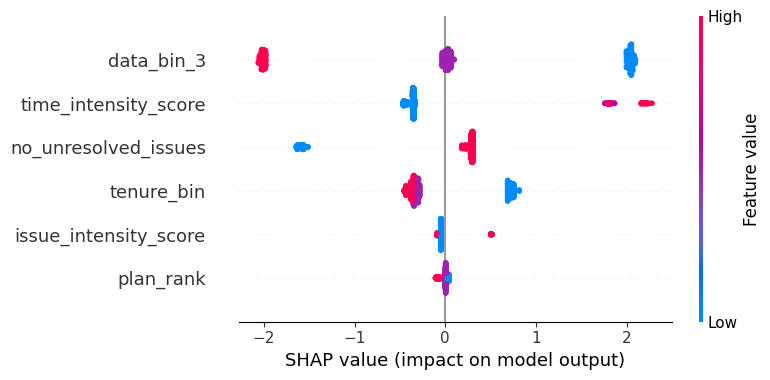

SHAP Waterfall for retention_score (Single Prediction)


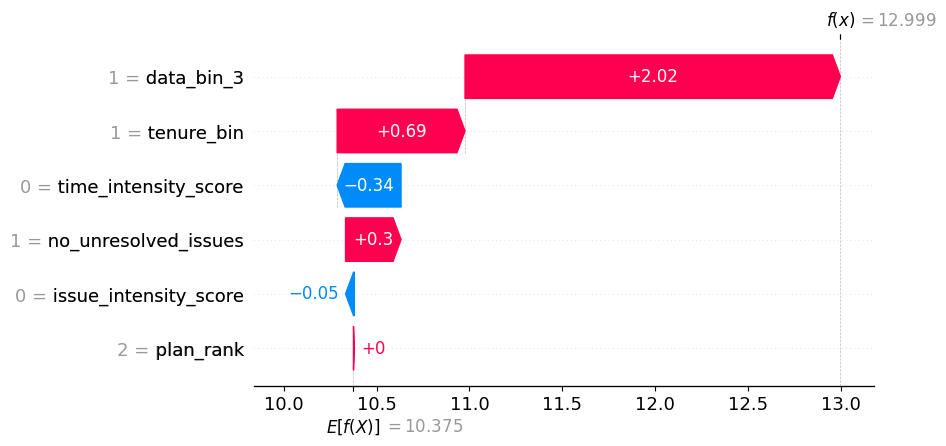

Training model for target: xsell_score
SHAP Summary for xsell_score


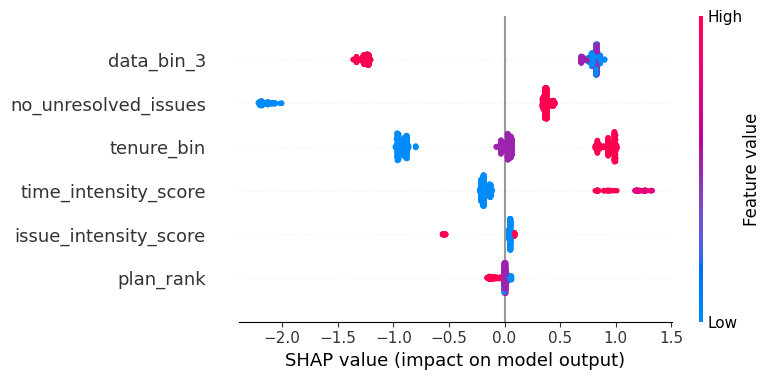

SHAP Waterfall for xsell_score (Single Prediction)


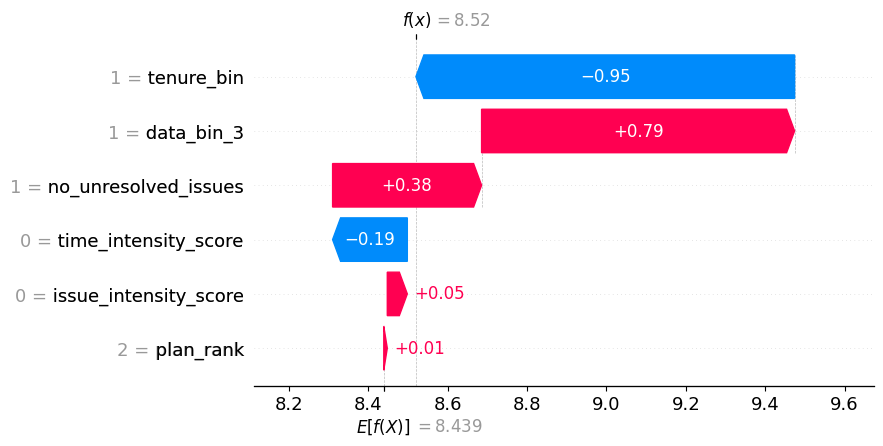

Training model for target: upsell_score
SHAP Summary for upsell_score


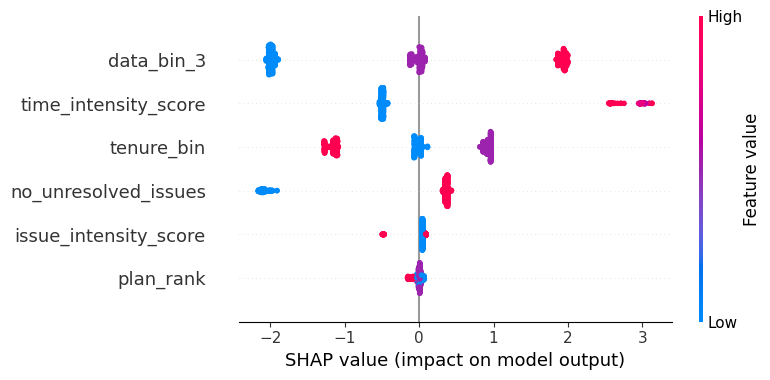

SHAP Waterfall for upsell_score (Single Prediction)


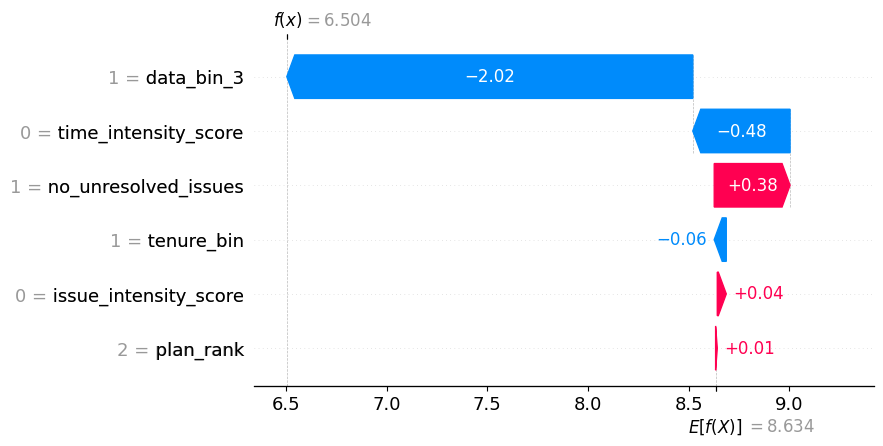

Training model for target: scaled_estimated_business_value
SHAP Summary for scaled_estimated_business_value


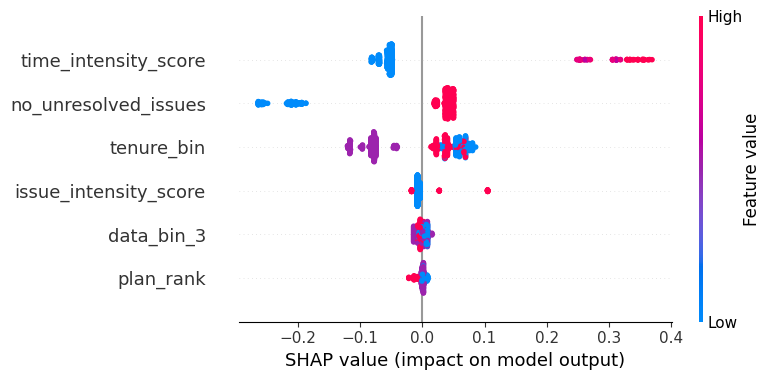

SHAP Waterfall for scaled_estimated_business_value (Single Prediction)


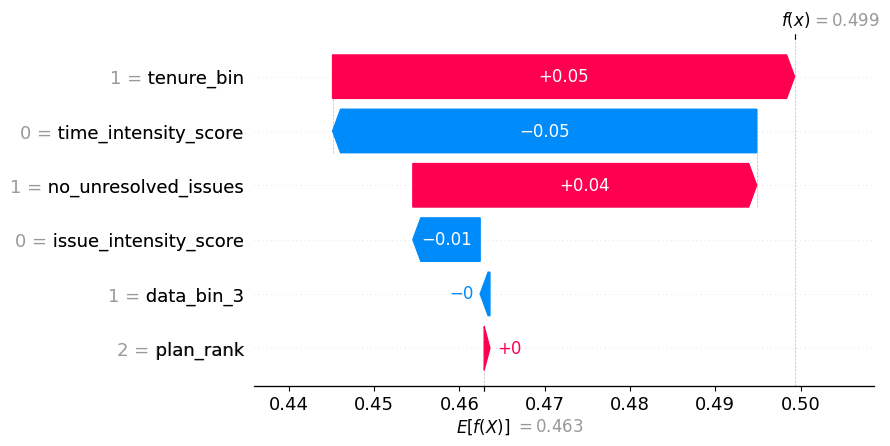

SHAP analysis completed for all targets.


In [219]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Ensure filtered_xgb_dataset only includes customers above churn probability threshold
filtered_xgb_dataset = merged_data[merged_data["churn_proba"] > proba_threshold].copy()

# Select only relevant features
selected_features = [
    "no_unresolved_issues", "time_intensity_score", "tenure_bin", 
    "issue_intensity_score", "plan_rank", "data_bin_3"
]

# Define targets
target_variables = ["retention_score", "xsell_score", "upsell_score", "scaled_estimated_business_value"]

# Store SHAP explanations
shap_explanations = {}

# Iterate through each target variable
for target in target_variables:
    print(f"Training model for target: {target}")

    # Ensure no NaN values in features and target
    filtered_data = filtered_xgb_dataset[selected_features + [target]].dropna()

    # Splitting into train-test sets
    X = filtered_data[selected_features]
    y = filtered_data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define and train XGBoost model
    model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    # Compute SHAP values
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)
    shap_explanations[target] = shap_values

    # **SHAP Summary Plot** (No need for matplotlib)
    print(f"SHAP Summary for {target}")
    shap.summary_plot(shap_values, X_test)

    # **SHAP Waterfall Plot for a single observation**
    print(f"SHAP Waterfall for {target} (Single Prediction)")
    shap.waterfall_plot(shap_values[0])  # Automatically uses the first sample

print("SHAP analysis completed for all targets.")